In [1]:
from intake import open_catalog
import datetime
import numpy as np
import pandas as pd
import scipy.io
import gsw
import gcsfs
import xarray as xr
from floater import rclv
from copy import deepcopy
from skimage import measure
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
# load the time of eddy identification
fn3 = '/home/jovyan/RCLVs/SCS/t_eddy.mat'
data3 = scipy.io.loadmat(fn3)

In [3]:
nyear = len(np.arange(1993, 2016, 1))
date_st = np.zeros((nyear*12,))

i = 0
for year in np.arange(1993, 2016, 1):
    for mon in np.arange(1, 13, 1):
        date_st[i] = datetime.date.toordinal(datetime.date(year, mon, 1))
        i += 1

In [5]:
# load ssh eddy information
df = pd.read_pickle('ssh_eddy.pkl')
df.head()

,id,date_start,date_end,duration,time,amplitude,area,radius,cyc,vorticity,boundary,center_traj,dx,speed_x,dy,speed_y,edgespd,KE
0,1,727951.0,727978.0,28.0,"[727951.0, 727952.0, 727953.0, 727954.0, 72795...","[-0.007712499999999983, -0.012131249999999968,...","[5455659440.894975, 8121446992.162614, 9907658...","[41672.41696480782, 50844.241244441546, 56157....",1,"[6.471079552603794e-06, 6.805875491400245e-06,...","[[[115.375, 115.625, 115.875, 116.125, 116.375...","[[115.875, 11.625], [115.875, 11.625], [115.62...",[-108913.97563481628],[-0.0450206579178308],[-305786.04827253654],[-0.12639965619731172],"[[0.13423669025789728], [0.17275709113497995],...","[[0.00470504440386122], [0.0110756746073456], ..."
1,2,727930.0,727978.0,49.0,"[727930.0, 727931.0, 727932.0, 727933.0, 72793...","[0.12278125000000001, 0.12778125, 0.1111187500...","[43276528576.180664, 43680949487.472404, 40409...","[117368.4237157236, 117915.5547828922, 113414....",-1,"[-5.640043829890309e-06, -5.616555549326674e-0...","[[[124.625, 124.57964887467716, 124.4362843058...","[[123.875, 20.125], [123.625, 20.125], [123.62...",[-391521.2849715277],[-0.09247951742524747],[222389.85328911748],[0.05252972725083085],"[[0.35392920090606994], [0.35248223420933167],...","[[0.04716042555755491], [0.044965167776585616]..."
2,3,727949.0,727982.0,34.0,"[727949.0, 727950.0, 727951.0, 727952.0, 72795...","[-0.009506249999999994, -0.021681249999999958,...","[6225675790.247264, 14753222515.156181, 180200...","[44516.22347201959, 68528.07147179543, 75736.2...",1,"[4.68624181126097e-06, 3.770623531094761e-06, ...","[[[118.375, 118.43338213762812, 118.6062312312...","[[118.875, 15.125], [118.875, 14.875], [118.62...",[-134178.6453078576],[-0.04567628176329575],[-55597.46332227937],[-0.018926151730078764],"[[0.12680375962826826], [0.15216259040720712],...","[[0.005702614188653442], [0.007613075801210582..."
3,4,727930.0,727985.0,56.0,"[727930.0, 727931.0, 727932.0, 727933.0, 72793...","[-0.0871875, -0.08626249999999999, -0.08258125...","[67125493398.966774, 62211634673.84232, 585548...","[146173.55494020082, 140721.63427255355, 13652...",1,"[4.7278965368901895e-06, 4.9974122119023494e-0...","[[[111.125, 111.375, 111.46845281638625, 111.6...","[[112.375, 9.625], [112.375, 9.625], [112.375,...",[-328888.84920378035],[-0.0679747125503845],[-138993.65830569842],[-0.02872719459029812],"[[0.37031183174407534], [0.37156503420446724],...","[[0.05419673412000216], [0.056296501822538224]..."
4,5,727944.0,727987.0,44.0,"[727944.0, 727945.0, 727946.0, 727947.0, 72794...","[0.007575000000000001, 0.012012500000000004, 0...","[8655732881.93327, 12941267500.89676, 15738534...","[52490.04999507501, 64182.03319687245, 70779.4...",-1,"[-4.21671231468934e-06, -4.214128511382315e-06...","[[[114.125, 114.27886710239652, 114.375, 114.6...","[[114.375, 10.375], [114.375, 10.375], [114.12...",[-164065.2907899769],[-0.0431569051951749],[-83396.19498341906],[-0.021937130414409475],"[[0.1075870142422782], [0.13724410868079404], ...","[[0.004261353721842516], [0.006642737660652458..."


In [26]:
cat = open_catalog("https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean.yaml")
ds_aviso  = cat["sea_surface_height"].to_dask()
ds_aviso

<xarray.Dataset>
Dimensions:    (latitude: 720, longitude: 1440, nv: 2, time: 8901)
Coordinates:
    crs        int32 ...
    lat_bnds   (time, latitude, nv) float32 dask.array<chunksize=(5, 720, 2), meta=np.ndarray>
  * latitude   (latitude) float32 -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
    lon_bnds   (longitude, nv) float32 dask.array<chunksize=(1440, 2), meta=np.ndarray>
  * longitude  (longitude) float32 0.125 0.375 0.625 0.875 ... 359.4 359.6 359.9
  * nv         (nv) int32 0 1
  * time       (time) datetime64[ns] 1993-01-01 1993-01-02 ... 2017-05-15
Data variables:
    adt        (time, latitude, longitude) float64 dask.array<chunksize=(5, 720, 1440), meta=np.ndarray>
    err        (time, latitude, longitude) float64 dask.array<chunksize=(5, 720, 1440), meta=np.ndarray>
    sla        (time, latitude, longitude) float64 dask.array<chunksize=(5, 720, 1440), meta=np.ndarray>
    ugos       (time, latitude, longitude) float64 dask.array<chunksize=(5, 720, 1440), meta=np.ndarray>
    ugosa      (time, latitude, longitude) float64 dask.array<chunksize=(5, 720, 1440), meta=np.ndarray>
    vgos       (time, latitude, longitude) float64 dask.array<chunksize=(5, 720, 1440), meta=np.ndarray>
    vgosa      (time, latitude, longitude) float64 dask.array<chunksize=(5, 720, 1440), meta=np.ndarray>
Attributes:
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Grid
    comment:                         Sea Surface Height measured by Altimetry...
    contact:                         servicedesk.cmems@mercator-ocean.eu
    creator_email:                   servicedesk.cmems@mercator-ocean.eu
    creator_name:                    CMEMS - Sea Level Thematic Assembly Center
    creator_url:                     http://marine.copernicus.eu
    date_created:                    2014-02-26T16:09:13Z
    date_issued:                     2014-01-06T00:00:00Z
    date_modified:                   2015-11-10T19:42:51Z
    geospatial_lat_max:              89.875
    geospatial_lat_min:              -89.875
    geospatial_lat_resolution:       0.25
    geospatial_lat_units:            degrees_north
    geospatial_lon_max:              359.875
    geospatial_lon_min:              0.125
    geospatial_lon_resolution:       0.25
    geospatial_lon_units:            degrees_east
    geospatial_vertical_max:         0.0
    geospatial_vertical_min:         0.0
    geospatial_vertical_positive:    down
    geospatial_vertical_resolution:  point
    geospatial_vertical_units:       m
    history:                         2014-02-26T16:09:13Z: created by DUACS D...
    institution:                     CLS, CNES
    keywords:                        Oceans > Ocean Topography > Sea Surface ...
    keywords_vocabulary:             NetCDF COARDS Climate and Forecast Stand...
    license:                         http://marine.copernicus.eu/web/27-servi...
    platform:                        ERS-1, Topex/Poseidon
    processing_level:                L4
    product_version:                 5.0
    project:                         COPERNICUS MARINE ENVIRONMENT MONITORING...
    references:                      http://marine.copernicus.eu
    source:                          Altimetry measurements
    ssalto_duacs_comment:            The reference mission used for the altim...
    standard_name_vocabulary:        NetCDF Climate and Forecast (CF) Metadat...
    summary:                         SSALTO/DUACS Delayed-Time Level-4 sea su...
    time_coverage_duration:          P1D
    time_coverage_end:               1993-01-01T12:00:00Z
    time_coverage_resolution:        P1D
    time_coverage_start:             1992-12-31T12:00:00Z
    title:                           DT merged all satellites Global Ocean Gr...

In [57]:
gcs = gcsfs.GCSFileSystem(requester_pays=True)

lev1 = np.arange(-1, 1.01, 0.01)


x_left, x_right = 100, 130
y_south, y_north = 0, 28
dx = 32 * (x_right - x_left)
dy = 32 * (y_north - y_south)

leaky_data = np.zeros((1999, 22))
leaky_data[:, :] = np.NaN

intru_data = np.zeros((1999, 20))
intru_data[:, :] = np.NaN

for i in np.arange(1999):
    display(['eddy id: ' + str(df.id[i])])
    leaky_data[i, 0] = df.id[i]
    leaky_data[i, 1] = df.duration[i]
    #leaky_data[i, 2] = df.area[i]
    
    eddy_time = df.time[i] # lifetime of ssh eddy
    
    date0_str = datetime.date.fromordinal(int(eddy_time[0]-366)).strftime('%Y-%m-%d')
    print(date0_str)
    
    duration = df.duration[i]
    
    date_diff = (date_st - eddy_time[0] + 366).tolist()    # check the number!!!!!!
    
    min_diff = min([num for num in date_diff if num >= 0])
    print(min_diff)
    
    remain_days = df.duration[i] - min_diff # calculate the days left
    print(remain_days)
    freq = int(remain_days / 10) # the output of lagrangian data is 10 days
    
    start_day = eddy_time[0] - 366 + min_diff
    start_str = datetime.date.fromordinal(int(start_day)).strftime('%Y-%m-%d')
    print(start_str)
    
    sd_id = np.argwhere(eddy_time == (start_day+366))
    
    lg_fn = 'gs://pangeo-rclv-eddies/float_trajectories/' + start_str + '.zarr' # lagrangian particle file name
    
    ds = xr.open_zarr(gcs.get_mapper(lg_fn))
    ds_new = ds.sel(x0=slice(x_left, x_right), y0=slice(y_south, y_north))

    if sd_id.shape[0] > 0:
        
        leaky_data[i, 2] = df.area[i][sd_id]
        
        boundary = df.boundary[i]
        
        var_tmp = boundary[sd_id][0, 0]
        
        num2 = var_tmp[1, :] / (y_north - y_south) * dy  # position of y
        num1 = (var_tmp[0, :] - 100) / (x_right - x_left) * dx # position of x
    
        contour0 = np.zeros((var_tmp.shape[1], 2))
        contour0[:, 1] = num1
        contour0[:, 0] = num2
        
        labels = rclv.label_points_in_contours(ds_new.x[0, :, :].shape, [contour0])
        
        mask1 = deepcopy(labels)
        mask2 = deepcopy(labels)
        mask2[mask1==0] = 1
        mask2[mask1==1] = 0
        
        fig = plt.figure(figsize=(13, 5))

# day 0 
        nday = 0
        id1 = sd_id + nday * 10
        
        xx1 = int(df.center_traj[i][0][0]-3)
        xx2 = int(df.center_traj[i][0][0]+3)
        
        yy1 = int(df.center_traj[i][0][1]-3)
        yy2 = int(df.center_traj[i][0][1]+3)
        
        pxin1 = ds_new.x[nday, :, :] * mask1
        pyin1 = ds_new.y[nday, :, :] * mask1
        pxout1 = ds_new.x[nday, :, :] * mask2
        pyout1 = ds_new.y[nday, :, :] * mask2

        boun_tmp = boundary[id1][0, 0]

        plt.subplot(1, 3, 1)

        ds_aviso.sel(longitude=slice(100, 130), latitude=slice(0, 28), time=start_str).sla.plot.contour(levels=lev1, colors='k', linewidths=0.2)

        plt.scatter(pxin1, pyin1, s=1, color='r')
        plt.scatter(pxout1, pyout1, s=1, color='lightgreen')

        plt.plot(boun_tmp[0, :], boun_tmp[1, :], color='k')

        plt.xlim(xx1, xx2)
        plt.ylim(yy1, yy2)
        plt.xlabel('LON')
        plt.ylabel('LAT')
        plt.title(start_str)

# day 10
        if freq > 0:
            plt.subplot(1, 3, 2)
            nday = 1
            id2 = sd_id + nday * 10
            
            start_str2 = datetime.date.fromordinal(int(start_day+10)).strftime('%Y-%m-%d')

            pxin2 = ds_new.x[nday, :, :] * mask1
            pyin2 = ds_new.y[nday, :, :] * mask1
            pxout2 = ds_new.x[nday, :, :] * mask2
            pyout2 = ds_new.y[nday, :, :] * mask2

            boun_tmp = boundary[id2][0, 0]

            ds_aviso.sel(longitude=slice(100, 130), latitude=slice(0, 28), time=start_str2).sla.plot.contour(levels=lev1, colors='k', linewidths=0.2)

            plt.scatter(pxin2, pyin2, s=1, color='r')
            plt.scatter(pxout2, pyout2, s=1, color='lightgreen')

            plt.plot(boun_tmp[0, :], boun_tmp[1, :], color='k')

            plt.xlim(xx1, xx2)
            plt.ylim(yy1, yy2)
            plt.xlabel('LON')
            plt.ylabel('LAT')
            plt.title(start_str2)

# day 20
            if freq > 1:
                plt.subplot(1, 3, 3)
                nday = 2
                id2 = sd_id + nday * 10

                start_str3 = datetime.date.fromordinal(int(start_day+20)).strftime('%Y-%m-%d')

                pxin3 = ds_new.x[nday, :, :] * mask1
                pyin3 = ds_new.y[nday, :, :] * mask1
                pxout3 = ds_new.x[nday, :, :] * mask2
                pyout3 = ds_new.y[nday, :, :] * mask2

                boun_tmp = boundary[id2][0, 0]

                ds_aviso.sel(longitude=slice(100, 130), latitude=slice(0, 28), time=start_str3).sla.plot.contour(levels=lev1, colors='k', linewidths=0.2)

                plt.scatter(pxin3, pyin3, s=1, color='r')
                plt.scatter(pxout3, pyout3, s=1, color='lightgreen')

                plt.plot(boun_tmp[0, :], boun_tmp[1, :], color='k')

                plt.xlim(xx1, xx2)
                plt.ylim(yy1, yy2)
                plt.xlabel('LON')
                plt.ylabel('LAT')
                plt.title(start_str3)
        
        titlestr = 'Eddy ID: ' + str(i).zfill(4)
        plt.suptitle(titlestr, size=16)
        savename = './pics/eddy_' + str(i).zfill(4) + '.png'
        plt.savefig(savename, dpi=100, bbox_inches='tight')
        plt.close()

['eddy id: 1']

1993-01-22
10.0
18.0
1993-02-01


['eddy id: 2']

1993-01-01
0.0
49.0
1993-01-01


['eddy id: 3']

1993-01-20
12.0
22.0
1993-02-01


['eddy id: 4']

1993-01-01
0.0
56.0
1993-01-01


['eddy id: 5']

1993-01-15
17.0
27.0
1993-02-01


(10.0, 15.0)

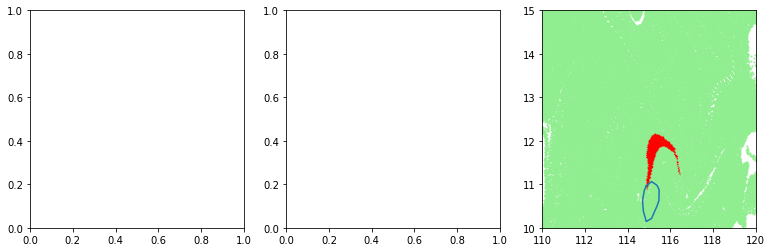

In [18]:
plt.figure(figsize=(13, 4))

plt.subplot(131)

plt.subplot(132)

plt.subplot(133)

plt.scatter(pxin, pyin, s=1, color='r')
plt.scatter(pxout, pyout, s=1, color='lightgreen')
plt.plot(boun_tmp[0, :], boun_tmp[1, :])

plt.xlim(110, 120)
plt.ylim(10, 15)

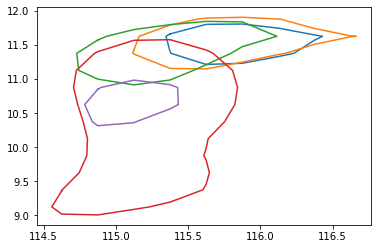

In [24]:
for i in np.arange(0,25,5):
    var = boundary[i]
    plt.plot(var[0, :], var[1, :])